In [1]:
# @title Librerias
# Google
#from google.colab import files # solo para google collab
from google.cloud import storage
import pandas as pd
print(storage.__version__)

# Datos
import json
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

# Graficos
import seaborn as sns
import matplotlib.pyplot as plt

# Analisis de sentimientos
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Modelos
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

2.8.0


In [2]:
# google collab
path_api_key = '/content/extreme-unison-399121-cadd77c555ca.json'

# entorno local
#path_api_key = '/Users/manuel/gdrive/prgrmmng/gcloud_api_key/extreme-unison-399121-cadd77c555ca.json'

# extraigo las credenciales para el acceso
service_account_info = json.load(open(path_api_key))

# autorizo el acceso a cloud storage
client_storage = storage.Client.from_service_account_info(service_account_info)

In [3]:
# cambiar segun bucket
bucket = client_storage.get_bucket('2_pipelines')

# cambiar segun dataframe
data_blob = bucket.blob('gmaps_metadata_filtrado.parquet')
data_gmaps_metadata = pd.read_parquet(storage.fileio.BlobReader(data_blob))
data_gmaps_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199691 entries, 0 to 199690
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   gmap_id          199691 non-null  object 
 1   name             199691 non-null  object 
 2   address          198340 non-null  object 
 3   description      61326 non-null   object 
 4   latitude         199691 non-null  float64
 5   longitude        199691 non-null  float64
 6   category         199691 non-null  object 
 7   avg_rating       199691 non-null  float64
 8   num_of_reviews   199691 non-null  int64  
 9   price            89913 non-null   object 
 10  hours-state_cat  199691 non-null  object 
 11  MISC             196007 non-null  object 
 12  hours            172059 non-null  object 
 13  geo_point        199691 non-null  object 
 14  zcta5_geoid      199691 non-null  object 
 15  geo_looker       199691 non-null  object 
 16  us_continente    199691 non-null  int6

In [4]:
# Elimino nan de Misc
independent_df = data_gmaps_metadata.copy()
independent_df.dropna(subset=['MISC'], inplace=True)
independent_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196007 entries, 0 to 199690
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   gmap_id          196007 non-null  object 
 1   name             196007 non-null  object 
 2   address          195046 non-null  object 
 3   description      61181 non-null   object 
 4   latitude         196007 non-null  float64
 5   longitude        196007 non-null  float64
 6   category         196007 non-null  object 
 7   avg_rating       196007 non-null  float64
 8   num_of_reviews   196007 non-null  int64  
 9   price            89722 non-null   object 
 10  hours-state_cat  196007 non-null  object 
 11  MISC             196007 non-null  object 
 12  hours            169738 non-null  object 
 13  geo_point        196007 non-null  object 
 14  zcta5_geoid      196007 non-null  object 
 15  geo_looker       196007 non-null  object 
 16  us_continente    196007 non-null  int6

In [5]:
# Creo una lista de diccionarios con 'MISC' y 'gmap_id'
attributes_list = [
    {**attributes, 'gmap_id': gmap_id}
    for attributes, gmap_id in zip(independent_df['MISC'], independent_df['gmap_id'])
]

# Creo un DataFrame a partir de la lista de diccionarios
attributes_df = pd.DataFrame(attributes_list)

print(attributes_df.columns)

Index(['Accessibility', 'Amenities', 'Atmosphere', 'Crowd', 'Dining options',
       'From the business', 'Health & safety', 'Health and safety',
       'Highlights', 'Offerings', 'Payments', 'Planning', 'Popular for',
       'Recycling', 'Service options', 'gmap_id'],
      dtype='object')


In [6]:
attributes_df

,Accessibility,Amenities,Atmosphere,Crowd,Dining options,From the business,Health & safety,Health and safety,Highlights,Offerings,Payments,Planning,Popular for,Recycling,Service options,gmap_id
0,[Wheelchair accessible seating],None,[Casual],[Groups],None,None,None,None,None,None,None,None,None,None,[Delivery],0x0:0x2ab217fc59211262
1,[Wheelchair accessible entrance],None,[Cozy],None,[Dessert],None,None,None,None,"[Comfort food, Healthy options, Small plates]",None,None,"[Dinner, Solo dining]",None,"[Takeout, Dine-in, Delivery]",0x14129c7a5c80b46d:0x33149e690acebdf
2,[Wheelchair accessible entrance],"[Good for kids, High chairs]","[Casual, Cozy]","[Groups, Tourists]",[Dessert],None,None,None,None,"[Alcohol, Beer, Coffee, Comfort food, Healthy ...",None,None,"[Lunch, Dinner, Solo dining]",None,"[Takeout, Dine-in, Delivery]",0x145e82e3ab31e247:0xbf25c482c904a5cd
3,[Wheelchair accessible seating],[Good for kids],[Casual],None,"[Breakfast, Lunch]",None,None,None,None,"[Coffee, Comfort food]",None,None,"[Breakfast, Lunch]",None,[Delivery],0x145e959979b43bb9:0x877799dfaf8f7e56
4,[Wheelchair accessible entrance],None,None,None,None,None,None,None,None,None,None,None,None,None,None,0x1467e2c2a2f3c0ad:0x1488e3f86c475ebf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196002,None,None,None,None,None,None,None,None,None,None,None,[Quick visit],None,None,"[In-store shopping, Takeout, Delivery]",0x89fca79a6338ba95:0x580cf9281b9b697f
196003,"[Wheelchair accessible entrance, Wheelchair ac...",None,[Casual],[Tourists],"[Breakfast, Lunch, Dessert, Seating]",None,None,None,"[Fast service, Fireplace, Great coffee]","[Alcohol, Beer, Cocktails, Coffee, Hard liquor...","[Debit cards, Credit cards]",None,[Breakfast],None,"[Outdoor seating, Takeout, Dine-in]",0x89fca7af1a667519:0xcc610fc9e4e96bd3
196004,[Wheelchair accessible entrance],"[Bar onsite, Gender-neutral restroom, Restroom]","[Casual, Cozy]","[Family-friendly, Tourists]","[Dinner, Dessert, Seating]",None,None,None,"[Great dessert, LGBTQ friendly, Transgender sa...","[Alcohol, Beer, Cocktails, Comfort food, Hard ...",[Credit cards],"[Dinner reservations recommended, Accepts rese...","[Dinner, Solo dining]",None,"[Outdoor seating, Takeout, Dine-in, Delivery]",0x89fca7f00c722f8b:0x90db6b0ea0214c64
196005,[Wheelchair accessible entrance],None,None,None,None,None,None,None,None,None,None,None,None,None,[Delivery],0x8c03681c967672f3:0x2bfe93cfccb0cd66


In [7]:
# Función para verificar si un atributo está presente en la lista o en None
def check_attribute_presence(service_options, attribute_name):
    if service_options is None:
        return 0
    return 1 if attribute_name in service_options else 0

In [8]:
attribute_name = 'Delivery'

# Aplico la función a la columna 'Service options' de attributes_df y guarda el resultado en el mismo DataFrame
attributes_df['RestaurantsDelivery'] = attributes_df['Service options'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'RestaurantsDelivery' con 0 (si no se encontró 'Delivery')
attributes_df['RestaurantsDelivery'].fillna(0, inplace=True)


In [9]:
attribute_name = 'Takeout'

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['RestaurantsTakeOut'] = attributes_df['Service options'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'RestaurantsTakeOut' con 0 (si no se encontró 'Takeout')
attributes_df['RestaurantsTakeOut'].fillna(0, inplace=True)

In [10]:
attribute_name = 'Outdoor seating'

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['OutdoorSeating'] = attributes_df['Service options'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'OutdoorSeating' con 0 (si no se encontró 'Outdoor seating')
attributes_df['RestaurantsTakeOut'].fillna(0, inplace=True)

In [11]:
attribute_name = 'Accepts reservations'

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['RestaurantsReservations'] = attributes_df['Planning'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'RestaurantsReservations' con 0 (si no se encontró 'Accepts reservations')
attributes_df['RestaurantsReservations'].fillna(0, inplace=True)

In [12]:
attribute_name = "Kids' menu"

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['GoodForKids'] = attributes_df['Offerings'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'GoodForKids' con 0 (si no se encontró 'Kids' menu')
attributes_df['GoodForKids'].fillna(0, inplace=True)

In [13]:
attribute_name = "Reservations required"

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['ByAppointmentOnly'] = attributes_df['Health and safety'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'ByAppointmentOnly' con 0 (si no se encontró 'Reservations required')
attributes_df['ByAppointmentOnly'].fillna(0, inplace=True)

In [14]:
attribute_name = "Wheelchair accessible seating"

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['WheelchairAccessible'] = attributes_df['Accessibility'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'WheelchairAccessible' con 0 (si no se encontró 'Wheelchair accessible seating')
attributes_df['WheelchairAccessible'].fillna(0, inplace=True)

In [19]:
# Genero una nueva funcion ya que a los proximos atibutos les voy a mandar una lista a verificar
# Función para verificar si al menos uno de los atributos está presente en la lista
def check_attributes(attribute_lista, attributes):
    if attribute_lista is None:
        return 0
    for attribute in attributes:
        if attribute in attribute_lista:
            return 1
    return 0

In [20]:
attribute_lista = ['Groups', 'Family-friendly', 'Family friendly', 'College students', 'University students']

# Aplico la función a la columna 'Crowd' de attributes_df y crea una nueva columna
attributes_df['RestaurantsGoodForGroups'] = attributes_df['Crowd'].apply(lambda x: check_attributes(x, attribute_lista))

# Lleno los valores NaN en 'RestaurantsGoodForGroups' con 0 (si no se encontró 'Groups','Family-friendly','Family friendly','College students','University students')
attributes_df['RestaurantsGoodForGroups'].fillna(0, inplace=True)

In [21]:
attribute_name = "Credit cards"

# Aplico la función a la columna 'Service options' de attributes_df
attributes_df['BusinessAcceptsCreditCards'] = attributes_df['Payments'].apply(lambda x: check_attribute_presence(x, attribute_name))

# Lleno los valores NaN en 'BusinessAcceptsCreditCards' con 0 (si no se encontró 'Credit cards')
attributes_df['BusinessAcceptsCreditCards'].fillna(0, inplace=True)

In [22]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196007 entries, 0 to 196006
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Accessibility               150947 non-null  object
 1   Amenities                   136962 non-null  object
 2   Atmosphere                  141018 non-null  object
 3   Crowd                       107219 non-null  object
 4   Dining options              105971 non-null  object
 5   From the business           9269 non-null    object
 6   Health & safety             57101 non-null   object
 7   Health and safety           7902 non-null    object
 8   Highlights                  69826 non-null   object
 9   Offerings                   147069 non-null  object
 10  Payments                    80116 non-null   object
 11  Planning                    41919 non-null   object
 12  Popular for                 130078 non-null  object
 13  Recycling                   8

In [23]:
# Selecciono las columnas deseadas
columnas_seleccionadas = attributes_df.iloc[:, 15:]

In [25]:
# Combino los datos actualizados en data_gmaps_metadata usando la columna 'gmap_id'
data_gmaps_metadata = data_gmaps_metadata.merge(columnas_seleccionadas, on='gmap_id', how='left')

In [26]:
data_gmaps_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209455 entries, 0 to 209454
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gmap_id                     209455 non-null  object 
 1   name                        209455 non-null  object 
 2   address                     208030 non-null  object 
 3   description                 62836 non-null   object 
 4   latitude                    209455 non-null  float64
 5   longitude                   209455 non-null  float64
 6   category                    209455 non-null  object 
 7   avg_rating                  209455 non-null  float64
 8   num_of_reviews              209455 non-null  int64  
 9   price                       91997 non-null   object 
 10  hours-state_cat             209455 non-null  object 
 11  MISC                        205771 non-null  object 
 12  hours                       181319 non-null  object 
 13  geo_point     

In [29]:
# Elimino nombres repetidos ya que los tomo como franquicias
# 'locations' es el número máximo de repeticiones permitidas para un 'name'
locations = 1

# Cuento la frecuencia de cada 'name'
name_counts = data_gmaps_metadata['name'].value_counts()

# Obtengo los nombres que cumplen con el criterio de frecuencia
valid_names = name_counts[name_counts <= locations].index

# Filtro el DataFrame original
data_gmaps_metadata = data_gmaps_metadata[data_gmaps_metadata['name'].isin(valid_names)]

data_gmaps_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128380 entries, 0 to 209454
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gmap_id                     128380 non-null  object 
 1   name                        128380 non-null  object 
 2   address                     127214 non-null  object 
 3   description                 17169 non-null   object 
 4   latitude                    128380 non-null  float64
 5   longitude                   128380 non-null  float64
 6   category                    128380 non-null  object 
 7   avg_rating                  128380 non-null  float64
 8   num_of_reviews              128380 non-null  int64  
 9   price                       38277 non-null   object 
 10  hours-state_cat             128380 non-null  object 
 11  MISC                        125133 non-null  object 
 12  hours                       109982 non-null  object 
 13  geo_point     

In [30]:
# Elimino la columna MISC ya que saque los atibutos que necesitaba
data_gmaps_metadata = data_gmaps_metadata.drop("MISC", axis=1)

In [32]:
# Elimino la columna price ya que saque los atibutos que necesitaba
data_gmaps_metadata = data_gmaps_metadata.drop("price", axis=1)

In [33]:
data_gmaps_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128380 entries, 0 to 209454
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gmap_id                     128380 non-null  object 
 1   name                        128380 non-null  object 
 2   address                     127214 non-null  object 
 3   description                 17169 non-null   object 
 4   latitude                    128380 non-null  float64
 5   longitude                   128380 non-null  float64
 6   category                    128380 non-null  object 
 7   avg_rating                  128380 non-null  float64
 8   num_of_reviews              128380 non-null  int64  
 9   hours-state_cat             128380 non-null  object 
 10  hours                       109982 non-null  object 
 11  geo_point                   128380 non-null  object 
 12  zcta5_geoid                 128380 non-null  object 
 13  geo_looker    

In [34]:
# Selecciono las columnas numéricas
columnas_numericas = ['avg_rating','RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards','RestaurantsTakeOut', 'ByAppointmentOnly', 'WheelchairAccessible', 'GoodForKids',
                      'RestaurantsReservations', 'RestaurantsGoodForGroups']

# Calculo la matriz de correlación
matriz_correlacion = data_gmaps_metadata[columnas_numericas]

matriz_correlacion = matriz_correlacion.loc[:, matriz_correlacion.std() != 0]

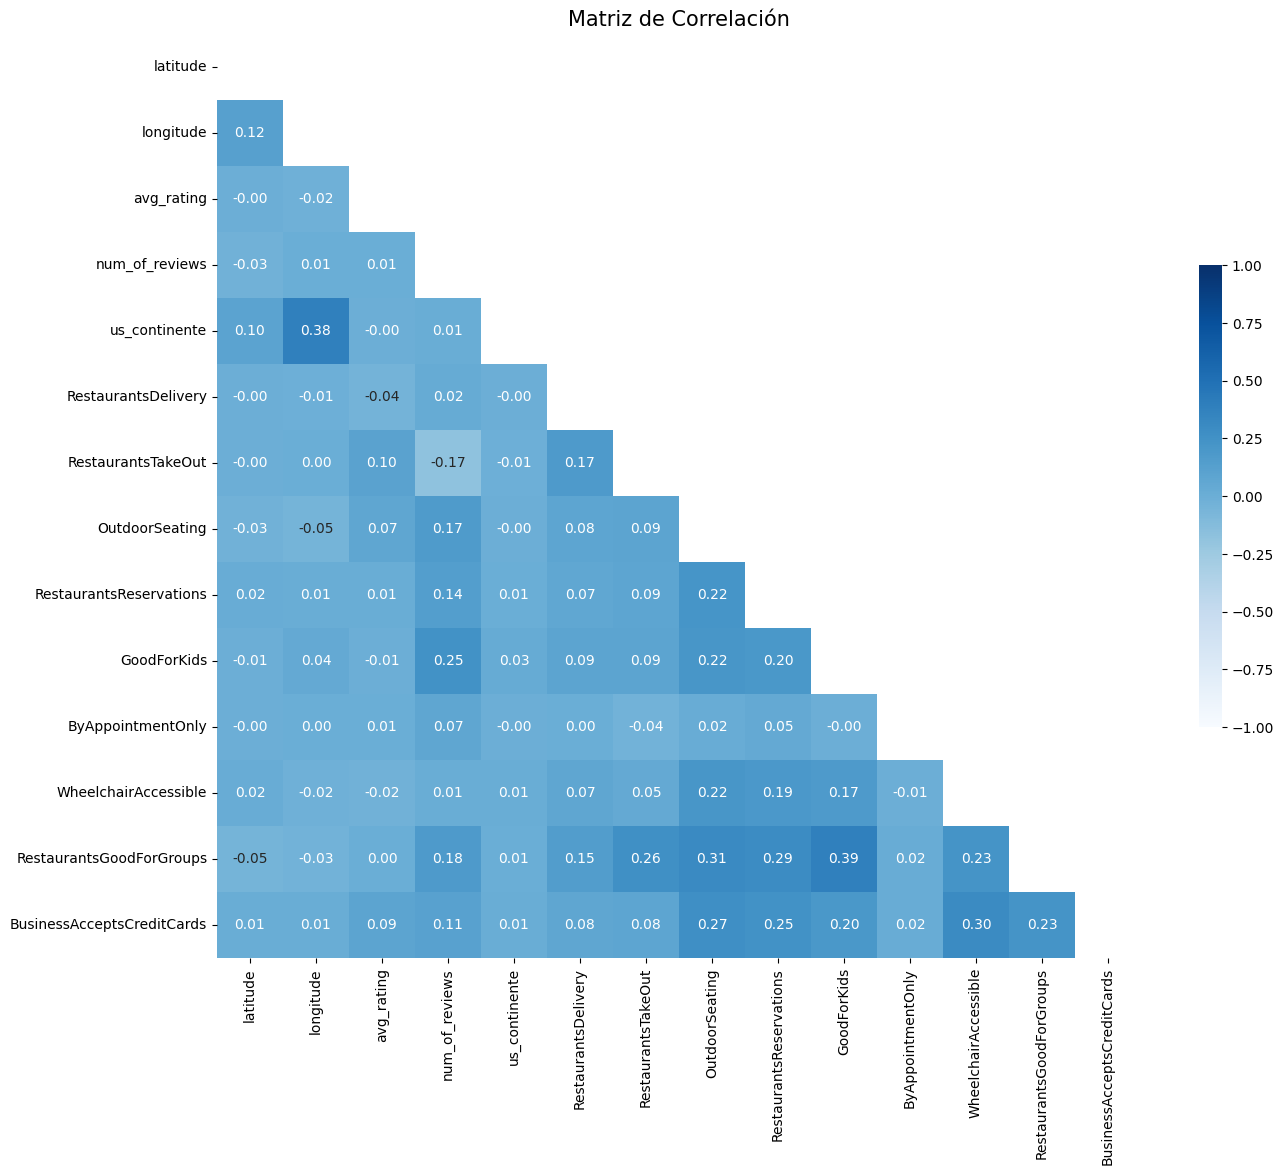

In [35]:
#Se Crea la correlacion entre las variables numericas:
correlation = data_gmaps_metadata.corr(numeric_only = True)

# Se genera una máscara para mostrar solo el triangulo inferior
mask = np.triu(correlation)
cor = plt.figure(figsize=(15,12)) # Defino el tamaño del grafico
ax = plt.axes()

#Se genera el mapa de calor
sns.heatmap(correlation,
            cbar = True,
            square = True,
            annot = True,
            fmt = '.2f',
            cmap = 'Blues',
            vmin =-1,
            vmax =1,
            center = 0,
            cbar_kws = {'shrink': 0.5},
            mask = mask,
            ax = ax
            )

ax.set_title("Matriz de Correlación",
             fontsize=15)

plt.show();

In [36]:
# Selecciono las columnas numéricas
columnas_numericas = ['avg_rating','RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards','RestaurantsTakeOut', 'ByAppointmentOnly', 'WheelchairAccessible', 'GoodForKids',
                      'RestaurantsReservations', 'RestaurantsGoodForGroups']

# Calculo la matriz de correlación
matriz_correlacion = data_gmaps_metadata[columnas_numericas]

In [37]:
data_gmaps_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128380 entries, 0 to 209454
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gmap_id                     128380 non-null  object 
 1   name                        128380 non-null  object 
 2   address                     127214 non-null  object 
 3   description                 17169 non-null   object 
 4   latitude                    128380 non-null  float64
 5   longitude                   128380 non-null  float64
 6   category                    128380 non-null  object 
 7   avg_rating                  128380 non-null  float64
 8   num_of_reviews              128380 non-null  int64  
 9   hours-state_cat             128380 non-null  object 
 10  hours                       109982 non-null  object 
 11  geo_point                   128380 non-null  object 
 12  zcta5_geoid                 128380 non-null  object 
 13  geo_looker    

In [38]:
# Reemplazo los valores NaN con 0 y lo guardo en un nuevo df
data_gmaps_metadata2 = data_gmaps_metadata.fillna(0)

In [39]:
# @title Modelo Random Forest

# Divido los datos originales en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data_gmaps_metadata2[['BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups', 'WheelchairAccessible', 'ByAppointmentOnly', 'GoodForKids', 'RestaurantsReservations', 'OutdoorSeating', 'RestaurantsTakeOut', 'RestaurantsDelivery']], data_gmaps_metadata2['avg_rating'], test_size=0.2, random_state=42)

In [41]:
# Creo y entreno un modelo Random Forest
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
# Realizo predicciones en el conjunto de prueba
y_pred = random_forest_model.predict(X_test)

In [43]:
# Creo un nuevo DataFrame para guardar las predicciones
predictions_df = X_test.copy()

# Asigno las predicciones al nuevo DataFrame
predictions_df['Predictions'] = y_pred

In [44]:
# Calculo el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Cuadrático Medio (MSE): 0.2458615996925067



En mi análisis del modelo que acabo de construir, es importante destacar que la variable que estamos tratando de predecir tiene un rango de valores de 0 a 5. Un Error Cuadrático Medio (MSE) de 0.2459, como el que hemos obtenido, podría considerarse relativamente alto en este contexto. En problemas donde la variable objetivo está en una escala de 0 a 5, un MSE cercano a cero indicaría que el modelo se ajusta muy bien a los datos y tiene un rendimiento bastante preciso.

Sin embargo, con un MSE de 0.2459, estamos observando un nivel de error que indica que el modelo podría no estar capturando completamente la variabilidad en los datos. Esto podría deberse a diversas razones, como la complejidad del problema, la elección de las características o la cantidad de datos disponibles.


In [45]:
# Uno las predicciones al DataFrame original
data_gmaps_metadata2 = data_gmaps_metadata2.join(predictions_df['Predictions'])

In [48]:
# Selecciono todas las filas en el DataFrame original para hacer predicciones
features_all = data_gmaps_metadata2[['BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups', 'WheelchairAccessible', 'ByAppointmentOnly', 'GoodForKids', 'RestaurantsReservations', 'OutdoorSeating', 'RestaurantsTakeOut', 'RestaurantsDelivery']]

# Realizo predicciones para todas las filas
predictions_all = random_forest_model.predict(features_all)  # Asegúrate de utilizar el modelo entrenado

# Agrego las predicciones como una nueva columna en el DataFrame original
data_gmaps_metadata2['Predictions'] = predictions_all

In [49]:
data_gmaps_metadata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128380 entries, 0 to 209454
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gmap_id                     128380 non-null  object 
 1   name                        128380 non-null  object 
 2   address                     128380 non-null  object 
 3   description                 128380 non-null  object 
 4   latitude                    128380 non-null  float64
 5   longitude                   128380 non-null  float64
 6   category                    128380 non-null  object 
 7   avg_rating                  128380 non-null  float64
 8   num_of_reviews              128380 non-null  int64  
 9   hours-state_cat             128380 non-null  object 
 10  hours                       128380 non-null  object 
 11  geo_point                   128380 non-null  object 
 12  zcta5_geoid                 128380 non-null  object 
 13  geo_looker    

In [50]:
# cambiar segun bucket
bucket = client_storage.get_bucket('2_pipelines')

# cambiar segun dataframe
data_blob = bucket.blob('data_gmaps_reviews_norm.parquet')
data_gmaps_reviews = pd.read_parquet(storage.fileio.BlobReader(data_blob))
data_gmaps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351896 entries, 0 to 2351895
Data columns (total 19 columns):
 #   Column           Dtype  
---  ------           -----  
 0   gmap_id          object 
 1   user_id          object 
 2   user_name        object 
 3   user_time        int64  
 4   rating           int64  
 5   user_text        object 
 6   resp_time        float64
 7   resp_text        object 
 8   user_time_year   int32  
 9   user_time_month  int32  
 10  user_time_day    int32  
 11  user_time_hms    object 
 12  resp_time_year   float64
 13  resp_time_month  float64
 14  resp_time_day    float64
 15  resp_time_hms    object 
 16  state_name       object 
 17  state_code       object 
 18  zcta5_geoid      int64  
dtypes: float64(4), int32(3), int64(3), object(9)
memory usage: 314.0+ MB


In [51]:
data_gmaps_reviews.head(5)

,gmap_id,user_id,user_name,user_time,rating,user_text,resp_time,resp_text,user_time_year,user_time_month,user_time_day,user_time_hms,resp_time_year,resp_time_month,resp_time_day,resp_time_hms,state_name,state_code,zcta5_geoid
0,0x88892bb449d44cb3:0x7beaf0b2e3171a49,110771718750038252970,Christian Buckner,1630031374725,2,"No masks, requested curbside and waited 10 min...",NaN,None,2021,8,27,02:29:34.725000,NaN,NaN,NaN,None,alabama,AL,35115
1,0x88892bb449d44cb3:0x7beaf0b2e3171a49,103436715724762727112,Dericc Williams,1624420177440,1,Bad attitudes rude and the owner must not care...,NaN,None,2021,6,23,03:49:37.440000,NaN,NaN,NaN,None,alabama,AL,35115
2,0x88892bb449d44cb3:0x7beaf0b2e3171a49,104877410053821600291,Susie Smith,1602297776261,5,This location does an awesome job! The delive...,NaN,None,2020,10,10,02:42:56.261000,NaN,NaN,NaN,None,alabama,AL,35115
3,0x88892bb449d44cb3:0x7beaf0b2e3171a49,116879073472364348668,Brenda Brown,1598537775889,4,Best pizza I've had in a long time,NaN,None,2020,8,27,14:16:15.889000,NaN,NaN,NaN,None,alabama,AL,35115
4,0x88892bb449d44cb3:0x7beaf0b2e3171a49,111158122526559360164,sonido pachuko king,1611369121997,1,"Terrible service, they don't know how to place...",NaN,None,2021,1,23,02:32:01.997000,NaN,NaN,NaN,None,alabama,AL,35115


In [52]:
# Descargo los recursos necesarios de NLTK si no los tienes ya
nltk.download('vader_lexicon')

# Inicializo el analizador de sentimientos VADER
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [53]:
# Función para clasificar el sentimiento basado en VADER
def compound_score(text):
    compound_score = 0  # Inico con un valor predeterminado
    if pd.notna(text) and isinstance(text, str):
        sentiment_score = sia.polarity_scores(text)
        compound_score = sentiment_score['compound']
    return compound_score

# Función para clasificar el sentimiento basado en VADER
def classify_sentiment_vader(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [54]:
# Aplico la función de clasificación de sentimientos al DataFrame
data_gmaps_reviews['compound_score'] = data_gmaps_reviews['user_text'].apply(compound_score)

In [55]:
# Aplico la función de classify_sentiment_vadera_dficación de sentimientos al DataFrame
data_gmaps_reviews['sentiment'] = data_gmaps_reviews['compound_score'].apply(classify_sentiment_vader)

In [56]:
# Asigno pesos a cada categoría de sentimiento
sentiment_weights = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Calculo el promedio ponderado para cada grupo 'gmap_id'
def ponderacion_average(group):
    # Calcula el producto de compound_score y su peso correspondiente según el sentimiento
    ponderacion_scores = group['compound_score'] * group['sentiment'].map(sentiment_weights)
    # Calcula el promedio ponderado
    return ponderacion_scores.sum() / ponderacion_scores.count()

In [57]:
# Aplico la función para calcular el promedio ponderado
ponderacion_avg_df = data_gmaps_reviews.groupby('gmap_id').apply(ponderacion_average).reset_index()
ponderacion_avg_df.columns = ['gmap_id', 'ponderacion_average']

In [58]:
# Realizo la fusión entre data_gmaps_metadata2 y ponderacion_avg_df
data_gmaps_metadata2 = data_gmaps_metadata2.merge(ponderacion_avg_df, on='gmap_id', how='left')

In [59]:
data_gmaps_metadata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128380 entries, 0 to 128379
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gmap_id                     128380 non-null  object 
 1   name                        128380 non-null  object 
 2   address                     128380 non-null  object 
 3   description                 128380 non-null  object 
 4   latitude                    128380 non-null  float64
 5   longitude                   128380 non-null  float64
 6   category                    128380 non-null  object 
 7   avg_rating                  128380 non-null  float64
 8   num_of_reviews              128380 non-null  int64  
 9   hours-state_cat             128380 non-null  object 
 10  hours                       128380 non-null  object 
 11  geo_point                   128380 non-null  object 
 12  zcta5_geoid                 128380 non-null  object 
 13  geo_looker    

In [60]:
# Me doy cuenta que estas columnas tendrian que ser numero entero y quedaron como float las paso a numero entero
columns_to_convert = ['RestaurantsDelivery', 'RestaurantsTakeOut', 'OutdoorSeating', 'RestaurantsReservations',
                      'GoodForKids', 'ByAppointmentOnly', 'WheelchairAccessible', 'RestaurantsGoodForGroups',
                      'BusinessAcceptsCreditCards']

data_gmaps_metadata2[columns_to_convert] = data_gmaps_metadata2[columns_to_convert].astype(int)


In [ ]:
data_gmaps_metadata2.isna().sum()


In [62]:
# Completo con 0 los valores faltantes de ponderacion
data_gmaps_metadata2.fillna(0, inplace=True)

In [63]:
data_gmaps_metadata2.isna().sum()

gmap_id                       0
name                          0
address                       0
description                   0
latitude                      0
longitude                     0
category                      0
avg_rating                    0
num_of_reviews                0
hours-state_cat               0
hours                         0
geo_point                     0
zcta5_geoid                   0
geo_looker                    0
us_continente                 0
state_name                    0
state_code                    0
RestaurantsDelivery           0
RestaurantsTakeOut            0
OutdoorSeating                0
RestaurantsReservations       0
GoodForKids                   0
ByAppointmentOnly             0
WheelchairAccessible          0
RestaurantsGoodForGroups      0
BusinessAcceptsCreditCards    0
Predictions                   0
ponderacion_average           0
dtype: int64

In [64]:
#@title Red Neural para elegir prospectos y tendencias

# Selecciono las características (features) y el objetivo (target)
features = ['Predictions', 'ponderacion_average', 'latitude', 'longitude', 'num_of_reviews', 'RestaurantsDelivery', 'RestaurantsTakeOut', 'OutdoorSeating', 'RestaurantsReservations','GoodForKids', 'ByAppointmentOnly', 'WheelchairAccessible', 'RestaurantsGoodForGroups','BusinessAcceptsCreditCards']
target = 'avg_rating'

In [65]:
# Divido los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data_gmaps_metadata2[features],data_gmaps_metadata2[target], test_size=0.2, random_state=42)

In [66]:
# Escalo las características para acelerar el entrenamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Creo el modelo de red neuronal
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compilo el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entreno el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Realizo predicciones en el conjunto de prueba
y_pred = model.predict(X_test)


Epoch 1/10
3210/3210 [==============================] - 6s 2ms/step - loss: 0.4556
Epoch 2/10
3210/3210 [==============================] - 5s 1ms/step - loss: 0.2583
Epoch 3/10
3210/3210 [==============================] - 5s 1ms/step - loss: 0.2535
Epoch 4/10
3210/3210 [==============================] - 5s 1ms/step - loss: 0.2510
Epoch 5/10
3210/3210 [==============================] - 5s 2ms/step - loss: 0.2498
Epoch 6/10
3210/3210 [==============================] - 5s 2ms/step - loss: 0.2489
Epoch 7/10
3210/3210 [==============================] - 5s 2ms/step - loss: 0.2485
Epoch 8/10
3210/3210 [==============================] - 5s 2ms/step - loss: 0.2476
Epoch 9/10
3210/3210 [==============================] - 5s 2ms/step - loss: 0.2474
Epoch 10/10
803/803 [==============================] - 1s 1ms/step


In [68]:
# Calculo el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Cuadrático Medio (MSE): 0.23869109195779525


In [69]:
# Ordeno los restaurantes por sus predicciones y ponderaciones promedio
data_gmaps_metadata2['predicted_rating'] = model.predict(scaler.transform(data_gmaps_metadata2[features]))
top_restaurants = data_gmaps_metadata2.sort_values(by=['state_name', 'predicted_rating'], ascending=[True, False])
bottom_restaurants = data_gmaps_metadata2.sort_values(by=['state_name', 'predicted_rating'], ascending=[True, True])

4012/4012 [==============================] - 4s 1ms/step


In [70]:
# Obtener los 5 mejores y 5 peores restaurantes de cada estado
top_restaurants = top_restaurants.groupby('state_name').head()
bottom_restaurants = bottom_restaurants.groupby('state_name').head()

In [71]:
# Mostro los primeros 5 restaurantes de top_restaurants
top_restaurants.head()

,gmap_id,name,address,description,latitude,longitude,category,avg_rating,num_of_reviews,hours-state_cat,...,OutdoorSeating,RestaurantsReservations,GoodForKids,ByAppointmentOnly,WheelchairAccessible,RestaurantsGoodForGroups,BusinessAcceptsCreditCards,Predictions,ponderacion_average,predicted_rating
97318,0x89b658f0225dbd83:0x94b6d5a9cd9a11e0,The Cookie Momster Kitchen,0,0,17.729352,-64.734370,bakery,5.0,6,Specific Hours,...,0,0,0,0,0,0,0,4.374790,0.000000,4.356925
79998,0x88891dd0fa60ffd1:0xabe9bf4bb1caff85,Heritage Coffee,"Heritage Coffee, 400 19th St Ens, c, Birmingha...",0,33.513855,-86.897686,cafe,4.9,28,Open,...,0,0,0,0,0,1,1,4.468552,1.492360,4.774838
75629,0x8862679969e04c53:0xf9c68f38d1bf2bb9,The Dessert Fork,"The Dessert Fork, 107 Brookridge Dr Suite E2, ...",0,34.749627,-86.758901,cafe,4.3,55,Open,...,0,0,0,0,0,1,1,4.468552,1.448178,4.759167
81256,0x889a06f6cfde250f:0xb605fa94bab34f52,Beach Jerky Life,"Beach Jerky Life, 108 W 3rd Ave, Gulf Shores, ...",0,30.251035,-87.690181,food products supplier,4.9,77,Open,...,0,0,0,0,0,0,1,4.517119,1.349500,4.752331
81041,0x88928e3213da0e31:0xd4ea461427ea85b3,The Dinner Bell Cafe,"The Dinner Bell Cafe, 800 Airport Dr # 9, Doth...",0,31.314874,-85.448721,american restaurant,4.5,38,Open,...,0,0,0,0,0,1,1,4.468552,1.777000,4.742748


In [72]:
# Lista de columnas deseadas
columnas_deseadas = [
    'gmap_id', 'name', 'address', 'latitude', 'longitude', 'avg_rating',
    'zcta5_geoid', 'state_name', 'state_code', 'RestaurantsDelivery',
    'RestaurantsTakeOut', 'OutdoorSeating', 'RestaurantsReservations',
    'GoodForKids', 'ByAppointmentOnly', 'WheelchairAccessible',
    'RestaurantsGoodForGroups', 'BusinessAcceptsCreditCards',
    'Predictions', 'ponderacion_average', 'predicted_rating'
]

# Selecciono las columnas deseadas
data_gmaps_metadata2 = data_gmaps_metadata2[columnas_deseadas]

# Renombro las columnas
nombres_columnas = {
    'gmap_id': 'id',
    'avg_rating': 'rating',
    'Predictions': 'predictions',
    'ponderacion_average': 'weighted_avg',
    'predicted_rating': 'predicted_rating'
}

data_gmaps_metadata2 = data_gmaps_metadata2.rename(columns=nombres_columnas)